In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import random

In [9]:
# Define dataset class
class LensDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ["no", "sphere", "vort"]
        self.image_paths = []
        self.labels = []
        
        # Load file paths and labels
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for file in os.listdir(class_dir):
                if file.endswith('.npy'):
                    self.image_paths.append(os.path.join(class_dir, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load image from .npy file
        image = np.load(image_path)
        image = np.stack([image] * 3, axis=-1)
        image = torch.from_numpy(image).float()

            

        if self.transform:
            image = self.transform(image)

        return image, label



KeyboardInterrupt: 

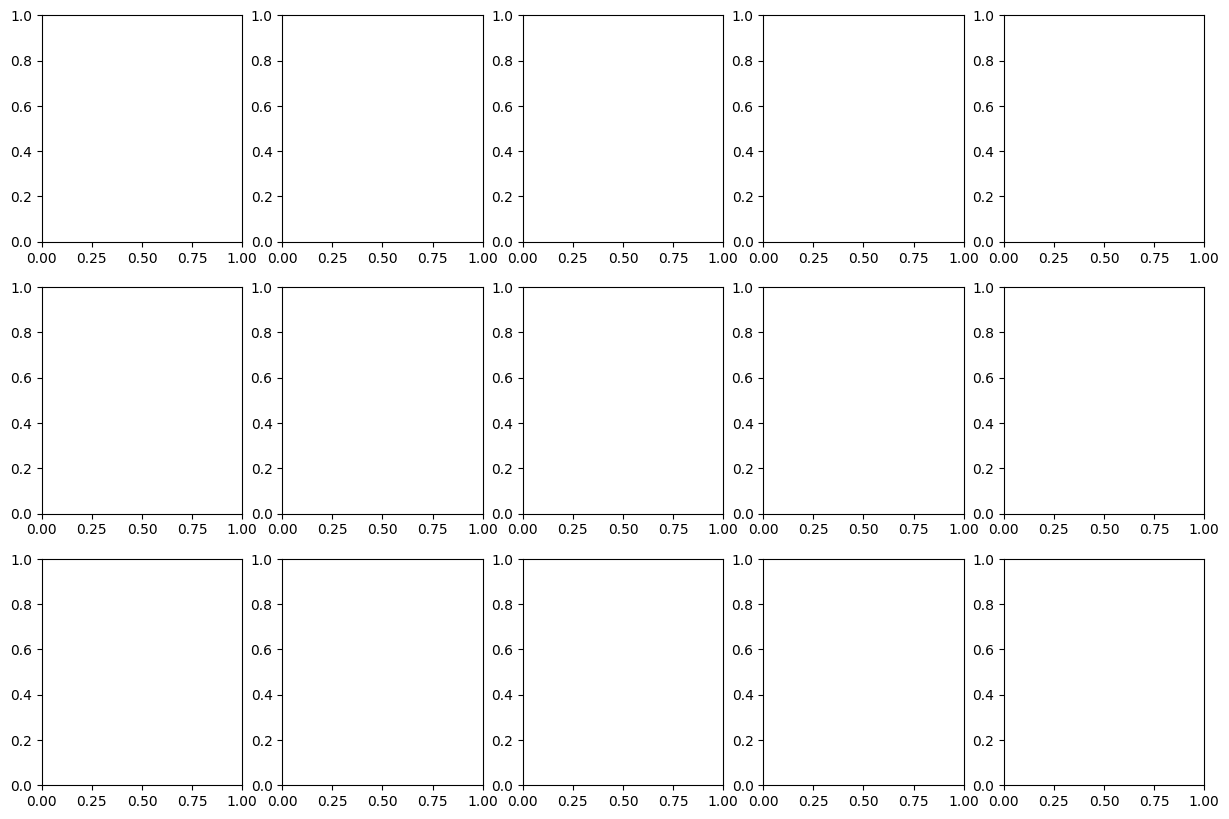

In [ ]:
# Define transformations
transform = transforms.Compose([
    # transforms.Resize((224, 224)),  # Resize for DenseNet/ResNet
    # transforms.RandomHorizontalFlip(),
    # transforms.ToTensor()
])

# Load train and validation datasets
train_dataset = LensDataset("D:\my_study\GSOC\dataset\dataset\train", transform=transform)
val_dataset = LensDataset("D:\my_study\GSOC\dataset\dataset\val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Function to display sample images
def show_class_samples(dataset, title, num_images=5):
    fig, axes = plt.subplots(len(dataset.classes), num_images, figsize=(15, 10))
    for class_idx, class_name in enumerate(dataset.classes):
        class_samples = [dataset[i] for i in range(len(dataset)) if dataset.labels[i] == class_idx][:num_images]
        for j, (image, label) in enumerate(class_samples):
            axes[class_idx, j].imshow(image.permute(1, 2, 0), cmap="gray")
            axes[class_idx, j].set_title(f"{title}: {class_name}")
            axes[class_idx, j].axis("off")
    plt.show()
# Display samples from train and val set
show_class_samples(train_dataset, "Train Set")
show_class_samples(val_dataset, "Validation Set")

In [12]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("wandb_api_key") 

wandb.login(key=my_secret)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: pechetti-1. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [31]:
wandb.init(project="lens_classification")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet = models.densenet161(pretrained=True)
resnet = models.resnet18(pretrained=True)

# Modify the classifier for 3 classes
densenet.classifier = nn.Sequential(
    nn.Linear(2208, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(p=0.33),
    nn.Linear(1024, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Dropout(p=0.33),
    nn.Linear(64, 3)
)

resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(p=0.33),
    nn.Linear(1024, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Dropout(p=0.33),
    nn.Linear(64, 3)
)

densenet.to(device)
resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_densenet = optim.Adam(densenet.parameters(), lr=1e-4)
optimizer_resnet = optim.Adam(resnet.parameters(), lr=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-dat

In [33]:
sections_densenet = {
    "classifier": (list(densenet.classifier.parameters()),5),
    "features_late": (list(densenet.features[10:].parameters()),3),
    "features_mid": (list(densenet.features[6:10].parameters()),7),
    "features_early": (list(densenet.features[:6].parameters()),15)
}

sections_resnet = {
    "fc": list(resnet.fc.parameters()),
    "layer4": list(resnet.layer4.parameters()),
    "layer3": list(resnet.layer3.parameters()),
    "layer2": list(resnet.layer2.parameters()),
    "layer1": list(resnet.layer1.parameters()),
    "conv1": list(resnet.conv1.parameters())
}

In [39]:
def train_model(model, optimizer, name, sections):
    model.train()
    for param in model.parameters():
        param.requires_grad = False
    
    for section_name, (section_params,num_epochs) in sections.items():
        for param in section_params:
            param.requires_grad = True
        
        for epoch in range(num_epochs):  # Train each section until saturation
            running_loss = 0.0
            correct, total = 0, 0
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)
            train_loss = running_loss / len(train_loader)
            train_acc = correct / total

            if (epoch + 1) % 2 == 0:
                torch.save(model.state_dict(), f"{name}_{section_name}_epoch{epoch+1}.pth")
                 
            # Validation
            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    val_correct += (outputs.argmax(1) == labels).sum().item()
                    val_total += labels.size(0)
            val_loss /= len(val_loader)
            val_acc = val_correct / val_total
            
            wandb.log({
                f"{name} Train Loss": train_loss,
                f"{name} Train Accuracy": train_acc,
                f"{name} Validation Loss": val_loss,
                f"{name} Validation Accuracy": val_acc
            })
            
            print(f"{name} {section_name} - Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
    

In [40]:
class LensDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ["no", "sphere", "vort"]
        self.image_paths = []
        self.labels = []
        
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for file in os.listdir(class_dir):
                if file.endswith('.npy'):
                    self.image_paths.append(os.path.join(class_dir, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = np.load(image_path).astype(np.float32)
        
        # Ensure the image has 2D or 3D shape compatible with PyTorch
        if image.ndim == 2:  # Grayscale image
            image = np.stack([image] * 3, axis=0)  # Convert to 3 channels (C, H, W)
        elif image.ndim == 3 and image.shape[0] == 1:  # Single-channel image
            image = np.squeeze(image, axis=0)  # Remove the extra channel dimension
            image = np.stack([image] * 3, axis=0)  # Convert to 3 channels
        
        if self.transform:
            image = torch.tensor(image)  # Convert to tensor
            image = self.transform(image)  # Apply transformations
        
        return image.to(device), torch.tensor(label, dtype=torch.long, device=device)

In [41]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for DenseNet/ResNet
    transforms.RandomHorizontalFlip(),
    # transforms.ToTensor(),
])

# Load train and validation datasets
train_dataset = LensDataset(r"/kaggle/input/multiclass-classification-gravitational-lensing/dataset/train", transform=transform)
val_dataset = LensDataset(r"/kaggle/input/multiclass-classification-gravitational-lensing/dataset/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
train_model(densenet, optimizer_densenet, "DenseNet", sections_densenet)

DenseNet classifier - Epoch 1: Train Loss=1.1342, Train Acc=0.3867, Val Loss=1.0625, Val Acc=0.4355
DenseNet classifier - Epoch 2: Train Loss=1.0786, Train Acc=0.4229, Val Loss=1.0532, Val Acc=0.4464
DenseNet classifier - Epoch 3: Train Loss=1.0588, Train Acc=0.4363, Val Loss=1.0449, Val Acc=0.4565
DenseNet classifier - Epoch 4: Train Loss=1.0440, Train Acc=0.4532, Val Loss=1.0415, Val Acc=0.4559
DenseNet classifier - Epoch 5: Train Loss=1.0349, Train Acc=0.4615, Val Loss=1.0397, Val Acc=0.4585
DenseNet features_late - Epoch 1: Train Loss=1.0204, Train Acc=0.4693, Val Loss=0.9738, Val Acc=0.5080
DenseNet features_late - Epoch 2: Train Loss=0.9426, Train Acc=0.5394, Val Loss=0.9573, Val Acc=0.5241
DenseNet features_late - Epoch 3: Train Loss=0.8912, Train Acc=0.5748, Val Loss=0.9604, Val Acc=0.5205
DenseNet features_mid - Epoch 1: Train Loss=0.7368, Train Acc=0.6731, Val Loss=0.5555, Val Acc=0.7800
DenseNet features_mid - Epoch 2: Train Loss=0.4679, Train Acc=0.8185, Val Loss=0.5760, Va

In [30]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()